<a href="https://colab.research.google.com/github/mayuresh-99/fintech-financial-models/blob/main/Financial_Data_Analytics_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
Tickers = ['NVDA','META','GOOGL']
START_DATE = "2018-01-01"
END_DATE = None

In [3]:
def fetch_price_data(tickers,start,end=None):
    data = yf.download(
        tickers,
        start = start,
        end = end,
        auto_adjust= True,
        progress = False
    )['Close']
    return data.dropna()

In [4]:
prices = fetch_price_data(Tickers,START_DATE,END_DATE)
prices

Ticker,GOOGL,META,NVDA
Date,,,
2018-01-02,53.258095,180.161514,4.928532
2018-01-03,54.166733,183.388962,5.252899
2018-01-04,54.377140,183.051331,5.280587
2018-01-05,55.098198,185.553864,5.325339
2018-01-08,55.292725,186.973938,5.488510
...,...,...,...
2025-12-26,313.510010,663.289978,190.529999
2025-12-29,313.559998,658.690002,188.220001
2025-12-30,313.850006,665.950012,187.539993


In [5]:
df = pd.DataFrame(prices)
df

Ticker,GOOGL,META,NVDA
Date,,,
2018-01-02,53.258095,180.161514,4.928532
2018-01-03,54.166733,183.388962,5.252899
2018-01-04,54.377140,183.051331,5.280587
2018-01-05,55.098198,185.553864,5.325339
2018-01-08,55.292725,186.973938,5.488510
...,...,...,...
2025-12-26,313.510010,663.289978,190.529999
2025-12-29,313.559998,658.690002,188.220001
2025-12-30,313.850006,665.950012,187.539993


In [6]:
def validate_prices_data(data):
  assert not data.isnull().any().any(),"Missing Values Detected"
  assert data.index.is_monotonic_increasing, "Dates not Sorted"
  assert (data > 0).all().all(), "Non-Positive Values Detected"

validate_prices_data(df)

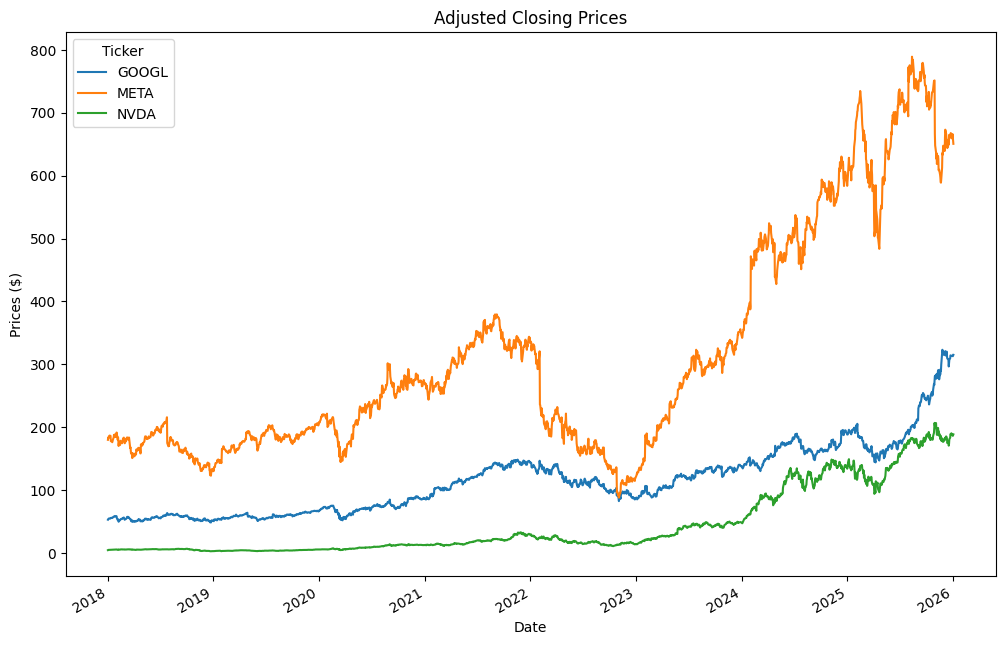

In [7]:
df.plot(figsize=(12,8),title = "Adjusted Closing Prices")
plt.ylabel("Prices ($)")
plt.show()


In [8]:
def compute_log_returns(data):

  data = np.log(data/data.shift(1))
  return data.dropna()

returns = compute_log_returns(df)
returns

Ticker,GOOGL,META,NVDA
Date,,,
2018-01-03,0.016917,0.017756,0.063739
2018-01-04,0.003877,-0.001843,0.005257
2018-01-05,0.013173,0.013579,0.008439
2018-01-08,0.003524,0.007624,0.030180
2018-01-09,-0.001275,-0.002180,-0.000270
...,...,...,...
2025-12-26,-0.001848,-0.006402,0.010128
2025-12-29,0.000159,-0.006959,-0.012198
2025-12-30,0.000924,0.010962,-0.003619


In [9]:
import pandas as pd
TRADING_DAYS = 252
def annualized_return_volatility(data_returns):

  annual_returns = TRADING_DAYS * data_returns.mean()
  annual_volatility = np.sqrt(TRADING_DAYS) * data_returns.std()

  return pd.DataFrame({
        "Annual Return": annual_returns,
        "Annual Volatility": annual_volatility
    })

In [10]:
metrics = annualized_return_volatility(returns)
metrics

,Annual Return,Annual Volatility
Ticker,,
GOOGL,0.222790,0.309816
META,0.160868,0.418715
NVDA,0.456872,0.512317


In [11]:
def rolling_volatility(data_returns , window=30):
    return data_returns.rolling(window).std()*np.sqrt(TRADING_DAYS)

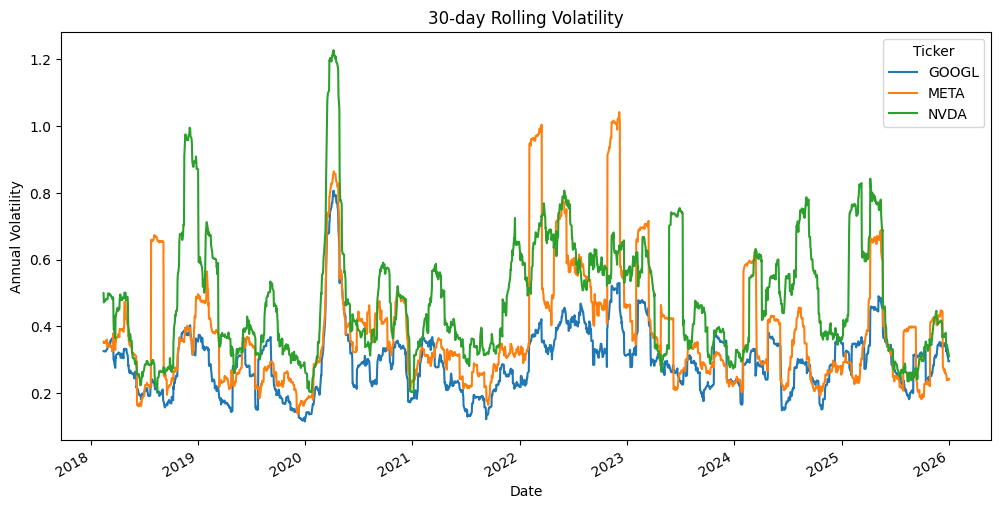

In [12]:
rolling_volatility = rolling_volatility(returns)

rolling_volatility.plot(figsize=(12,6) , title = "30-day Rolling Volatility")
plt.ylabel("Annual Volatility")
plt.show()

In [13]:
def compute_drawdown(data_returns):
  cumulative_max = data_returns.cummax()
  drawdown = (data_returns - cumulative_max)/cumulative_max
  return drawdown

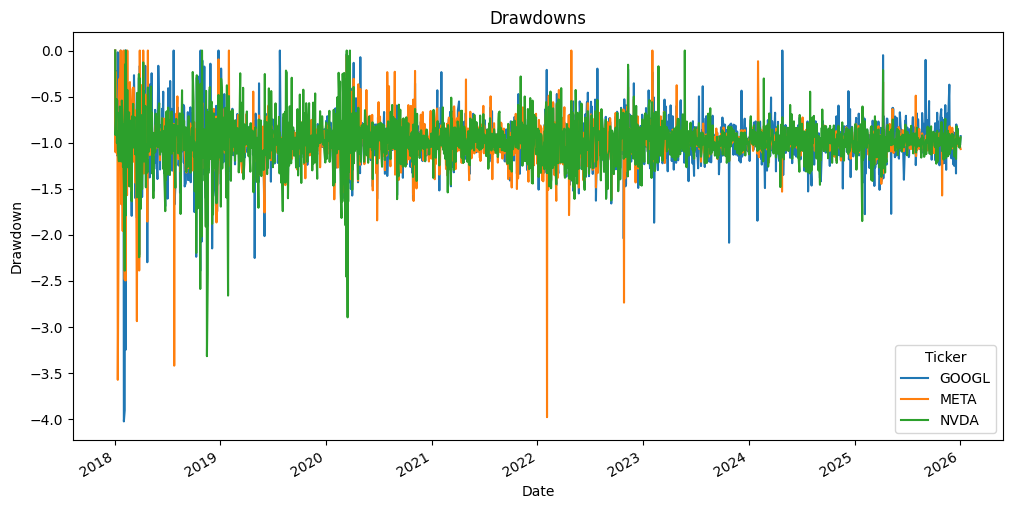

In [14]:
drawdown = compute_drawdown(returns)

drawdown.plot(figsize = (12,6), title = "Drawdowns")
plt.ylabel('Drawdown')
plt.show()

In [15]:
def correlation_matrix(data_returns):
  return data_returns.corr()

In [16]:
corr = correlation_matrix(returns)
corr

Ticker,GOOGL,META,NVDA
Ticker,,,
GOOGL,1.000000,0.605240,0.579023
META,0.605240,1.000000,0.521275
NVDA,0.579023,0.521275,1.000000


In [17]:
class RiskAnalytics:
  def __init__(self,df):
      self.df = df
      self.returns = compute_log_returns(df)
  def summary(self):
      metrics = annualized_return_volatility(self.returns)
      metrics["Max Drawdown"] = compute_drawdown(self.df).min()
      return metrics


In [18]:
analytics = RiskAnalytics(df)
analytics.summary()

,Annual Return,Annual Volatility,Max Drawdown
Ticker,,,
GOOGL,0.222790,0.309816,-0.443200
META,0.160868,0.418715,-0.767361
NVDA,0.456872,0.512317,-0.663351


Time Series Forecasting

In [19]:
!pip install arch

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

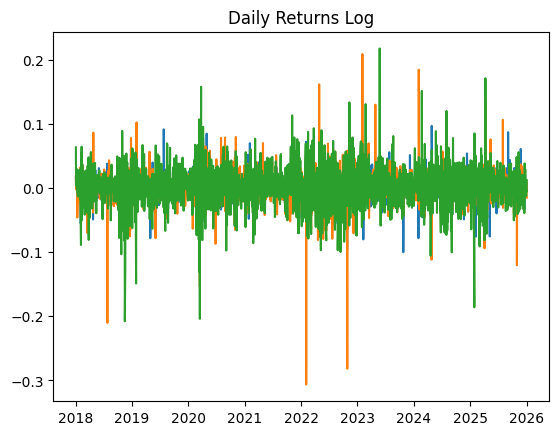

In [21]:
plt.figure()
plt.plot(returns)
plt.title("Daily Returns Log")
plt.show()

GOOGLE Time series Forecasting

In [22]:
arima_results = {}

for ticker in returns.columns:
  model = ARIMA(returns[ticker], order=(1,0,1))
  result = model.fit()
  arima_results[ticker] = result
  print(f'Results for {ticker}')
  print(result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Results for GOOGL
                               SARIMAX Results                                
Dep. Variable:                  GOOGL   No. Observations:                 2011
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5067.764
Date:                Sun, 04 Jan 2026   AIC                         -10127.529
Time:                        09:00:07   BIC                         -10105.103
Sample:                             0   HQIC                        -10119.297
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      2.147      0.032    7.65e-05       0.002
ar.L1          0.0116      0.263      0.044      0.965      -0.504       0.527
ma.L1         -0.0785      0.266  

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Results for META
                               SARIMAX Results                                
Dep. Variable:                   META   No. Observations:                 2011
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4460.078
Date:                Sun, 04 Jan 2026   AIC                          -8912.156
Time:                        09:00:09   BIC                          -8889.731
Sample:                             0   HQIC                         -8903.924
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.084      0.278      -0.001       0.002
ar.L1         -0.4932      0.277     -1.780      0.075      -1.036       0.050
ma.L1          0.4482      0.285   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Results for NVDA
                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                 2011
Model:                 ARIMA(1, 0, 1)   Log Likelihood                4060.475
Date:                Sun, 04 Jan 2026   AIC                          -8112.951
Time:                        09:00:12   BIC                          -8090.525
Sample:                             0   HQIC                         -8104.719
                               - 2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.601      0.009       0.000       0.003
ar.L1         -0.4618      0.164     -2.814      0.005      -0.783      -0.140
ma.L1          0.3793      0.171   

In [23]:
residuals_df = pd.DataFrame({
    ticker: result.resid
    for ticker, result in arima_results.items()
    })

In [24]:
garch_results ={}

for ticker in residuals_df.columns:
  model = arch_model(
      residuals_df[ticker],
      vol = 'garch',
      p= 1,
      q= 1,
      mean ="Zero"
      )
  garch_result = model.fit(disp ="off")
  garch_results[ticker] = garch_result
  print(f'Results for {ticker}')
  print(garch_result.summary())



/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006936. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


Results for GOOGL
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  GOOGL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5140.94
Distribution:                  Normal   AIC:                          -10275.9
Method:            Maximum Likelihood   BIC:                          -10259.1
                                        No. Observations:                 2011
Date:                Sun, Jan 04 2026   Df Residuals:                     2011
Time:                        09:00:12   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.6219e-05  7.087e-07     36.

/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)


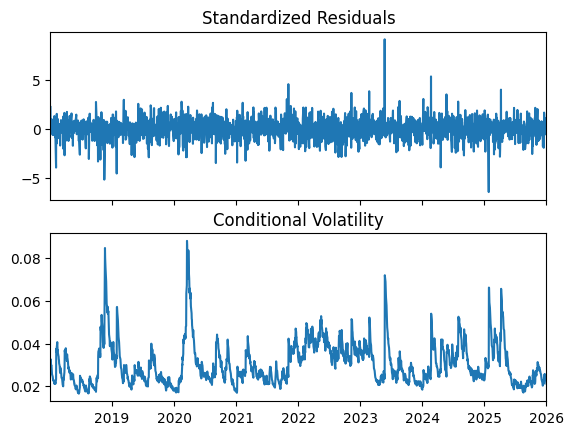

In [25]:
garch_result.plot()
plt.show()

In [26]:
forecast_horizon = 30
vol_forecast = garch_result.forecast(horizon = forecast_horizon)
forecast_variance = vol_forecast.variance.iloc[-1]
forecasted_volatility = np.sqrt(forecast_variance)

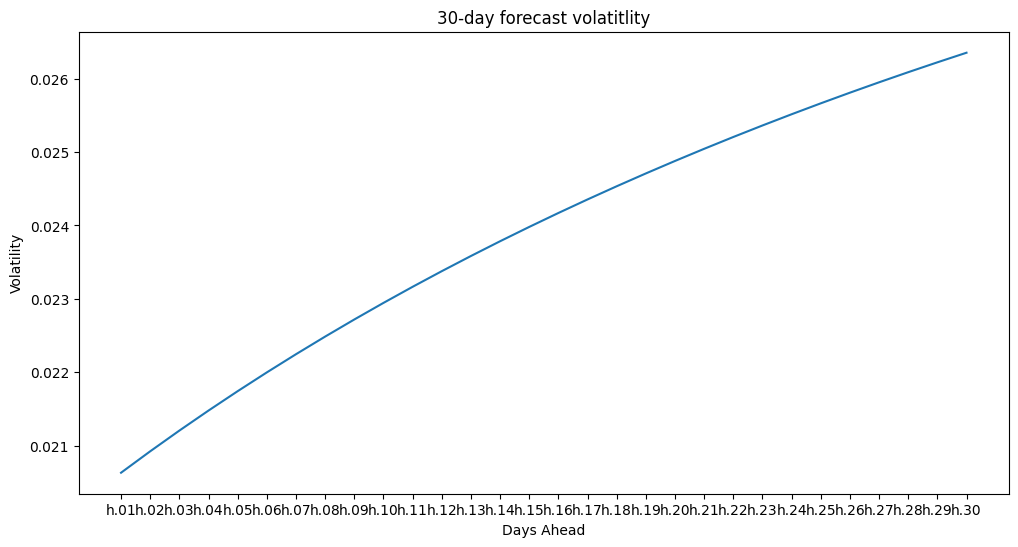

In [27]:
plt.figure(figsize=(12,6))
plt.plot(forecasted_volatility)
plt.title("30-day forecast volatitlity")
plt.xlabel('Days Ahead')
plt.ylabel('Volatility')
plt.show()


In [28]:

margin = 2.5 * forecasted_volatility

In [29]:
if forecasted_volatility.mean() > returns['NVDA'].std():
    print("High Volatility risk triggered")

In [31]:
summary = pd.DataFrame({
    "Metrics": [
        'Average Forecasted Volatility',
        'Current Realized Volatility',
        'Volatility Change (%)'
    ],
    "Value":[
        forecasted_volatility.mean(),
        returns['NVDA'].std(),
        (forecasted_volatility.mean() / returns['NVDA'].std() - 1) * 100
    ]
})
summary

,Metrics,Value
0,Average Forecasted Volatility,0.023871
1,Current Realized Volatility,0.032273
2,Volatility Change (%),-26.034703
